In [69]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import xgboost as xgb

# local libraries
import metrics as mt

In [70]:
clf_dict = {'LR':LogisticRegression, 
           'GB':GradientBoostingClassifier, 
           'XGB': xgb.XGBClassifier}
data_dict={}

In [291]:
state='KS'
year='2014'

for state in ['OH', 'DE', 'AK', 'HI', 'SD', 'PA', 'MI', 'GA', 'MS']: 
    data_dict[state] = {}
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]['x'] = features
    data_dict[state][year]['y'] = label
    data_dict[state][year]['g'] = group 

In [85]:
state='SD'
for year in ['2014', '2015', '2016', '2017', '2018']: 
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]['x'] = features
    data_dict[state][year]['y'] = label
    data_dict[state][year]['g'] = group 

In [73]:
# acoss years
results = [] 
for clf in clf_dict: 
    for i in range(5): 
        year = '2014'
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[state][year]['x'],
                    data_dict[state][year]['y'], 
                    data_dict[state][year]['g'], test_size=0.2, random_state=i)

        if clf == 'XBG': 
            model = make_pipeline(StandardScaler(), 
                                  clf_dict[clf](objective="binary:logistic"))
        else: 
            model = make_pipeline(StandardScaler(), clf_dict[clf]())

        model.fit(X_train, y_train)
        
        yhat = model.predict(X_test)
        corr = yhat == y_test
        g_acc_arr = mt.group_accuracy(corr, group_test) 

        results.append({
            'year': year, 
            'test_acc': model.score(X_test, y_test), 
            'disp': max(g_acc_arr) - min(g_acc_arr), 
            'worst_g': min(g_acc_arr), 
            'size': len(y_train), 
            'run': i, 
        })
        for year in data_dict[state].keys(): 
            
            X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[state][year]['x'],
                    data_dict[state][year]['y'], 
                    data_dict[state][year]['g'], test_size=0.4, random_state=i)
            yhat = model.predict(X_test)
            corr = yhat == y_test
            
            g_acc_arr = mt.group_accuracy(corr, group_test)
        
            results.append({
            'year': year, 
            'test_acc': model.score(X_test, y_test), 
            'disp': max(g_acc_arr) - min(g_acc_arr), 
            'worst_g': min(g_acc_arr), 
            'size': len(y_train), 
            'run': i, 
            'clf': clf,
        })

Text(0.5, 0.98, 'SD Model across different years trained on 2014')

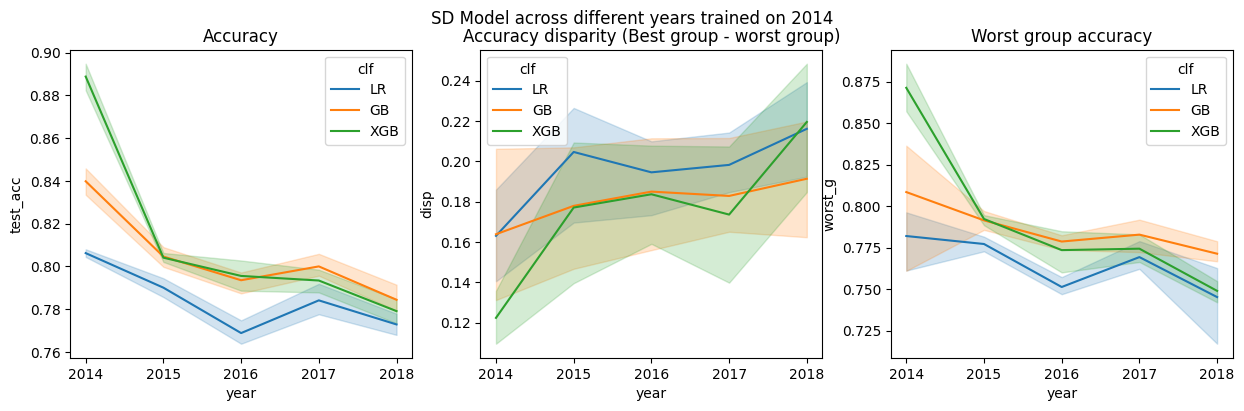

In [74]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x='year', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy")
sns.lineplot(data=results_df, x='year', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
sns.lineplot(data=results_df, x='year', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
plt.suptitle(f"{state} Model across different years trained on 2014")

In [298]:
# acoss states
results = [] 
year='2014'
for clf in clf_dict: 
    for i in range(5): 
        ref_state = 'CA'
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[ref_state][year]['x'],
                    data_dict[ref_state][year]['y'], 
                    data_dict[ref_state][year]['g'], test_size=0.2, random_state=i)

        if clf == 'XBG': 
            model = make_pipeline(StandardScaler(), 
                                  clf_dict[clf](objective="binary:logistic"))
        else: 
            model = make_pipeline(StandardScaler(), clf_dict[clf]())

        model.fit(X_train, y_train)
        
        yhat = model.predict(X_test)
        corr = yhat == y_test
        g_acc_arr = mt.group_accuracy(corr, group_test) 

        results.append({
            'year': year, 
            'state': ref_state, 
            'test_acc': model.score(X_test, y_test), 
            'disp': max(g_acc_arr) - min(g_acc_arr), 
            'worst_g': min(g_acc_arr), 
            'size': len(y_train), 
            'run': i, 
            'clf': clf,
        })
        for state in data_dict.keys(): 
            if state != ref_state: 
                X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                        data_dict[state][year]['x'],
                        data_dict[state][year]['y'], 
                        data_dict[state][year]['g'], test_size=0.4, random_state=i)
                yhat = model.predict(X_test)
                corr = yhat == y_test
                g_acc_arr = mt.group_accuracy(corr, group_test) 

                results.append({
                'year': year, 
                'state': state, 
                'test_acc': model.score(X_test, y_test), 
                'disp': max(g_acc_arr) - min(g_acc_arr), 
                'worst_g': min(g_acc_arr), 
                'size': len(y_train), 
                'run': i, 
                'clf': clf,
            })

Text(0.5, 0.98, '2014 CA model on other states')

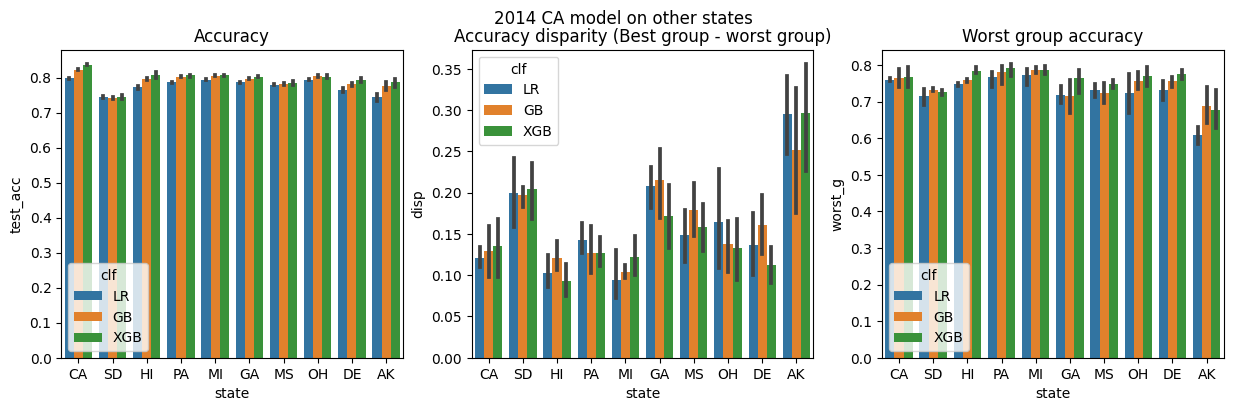

In [299]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=results_df, x='state', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy")
sns.barplot(data=results_df, x='state', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
sns.barplot(data=results_df, x='state', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
plt.suptitle(f"2014 {ref_state} model on other states")

In [79]:
results = [] 
state='SD'
year='2014'
size_arr = [50, 100, 500, 1000, 2000]
for clf in clf_dict.keys(): 
    for size in size_arr: 
        print(size)
        for run in range(5): 
            

            X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                data_dict[state][year]['x'], 
                data_dict[state][year]['y'], 
                data_dict[state][year]['g'], test_size=0.2, random_state=0)
            
            incl = np.asarray(random.sample(range(len(y_train)), size))
            
            X_train = X_train[incl]
            y_train = y_train[incl]
            if clf == 'XBG': 
                model = make_pipeline(StandardScaler(), 
                                      clf_dict[clf](objective="binary:logistic"))
            else: 
                model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_train, y_train)
            
            yhat = model.predict(X_test)
            corr = yhat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)

            results.append({
                'train_acc': train_acc, 
                'test_acc': test_acc, 
                'test_acc': model.score(X_test, y_test), 
                'disp': max(g_acc_arr) - min(g_acc_arr),
                'worst_g': min(g_acc_arr), 
                'size': size, 
                'run': run, 
                'clf': clf, 
            })

50
100
500
1000
2000
50
100
500
1000
2000
50
100
500
1000
2000


Text(0.5, 0.98, 'SD Model with increasing datasize')

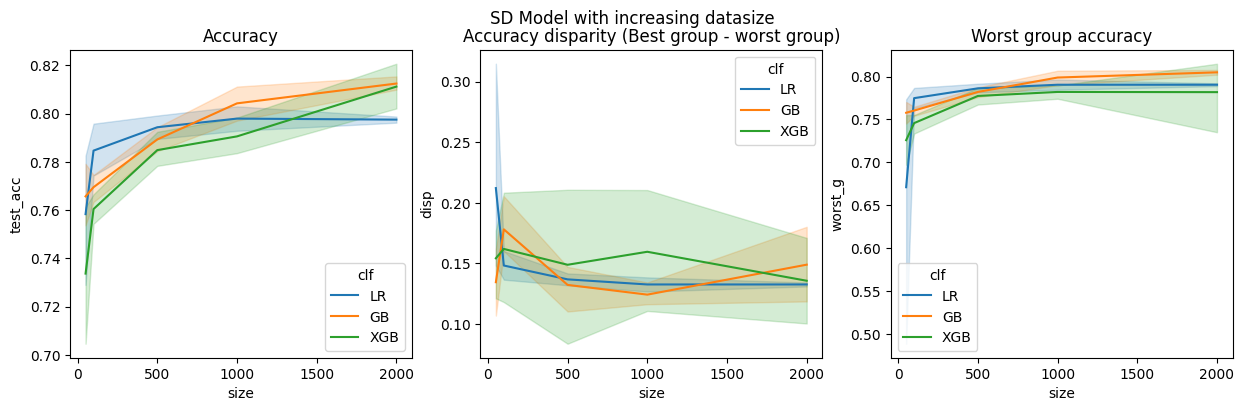

In [80]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x='size', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy")
sns.lineplot(data=results_df, x='size', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
sns.lineplot(data=results_df, x='size', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
plt.suptitle(f"{state} Model with increasing datasize")

In [325]:
# sequential

results = [] 
state='SD'
year='2014'
mixture = False  
size_arr = [50, 100, 500, 1000, 2000, 4000, 8000, 12000, 14000, 16000]
for run in range(5): 
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_dict[state][year]['x'], 
        data_dict[state][year]['y'], 
        data_dict[state][year]['g'], test_size=0.2, random_state=run)

    X_joint = np.concatenate((X_train, 
                            data_dict['CA'][year]['x']))
    y_joint = np.concatenate((y_train, 
                            data_dict['CA'][year]['y']))
    g_joint = np.concatenate((group_train, 
                            data_dict['CA'][year]['g']))
    
    if mixture: 
        p = np.random.permutation(len(X_joint))
        X_joint = X_joint[p]
        y_joint = y_joint[p]
        g_joint = g_joint[p]

    for clf in clf_dict.keys(): 

        for size in size_arr: 
            if clf == 'XBG': 
                model = make_pipeline(StandardScaler(), 
                                      clf_dict[clf](objective="binary:logistic"))
            else: 
                model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_joint[:size], y_joint[:size])

            yhat = model.predict(X_test)
            corr = yhat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)


            results.append({
                'train_acc': train_acc, 
                'test_acc': test_acc, 
                'disp': max(g_acc_arr) - min(g_acc_arr),
                'worst_g': min(g_acc_arr), 
                'size': size, 
                'run': run, 
                'clf': clf, 
            })

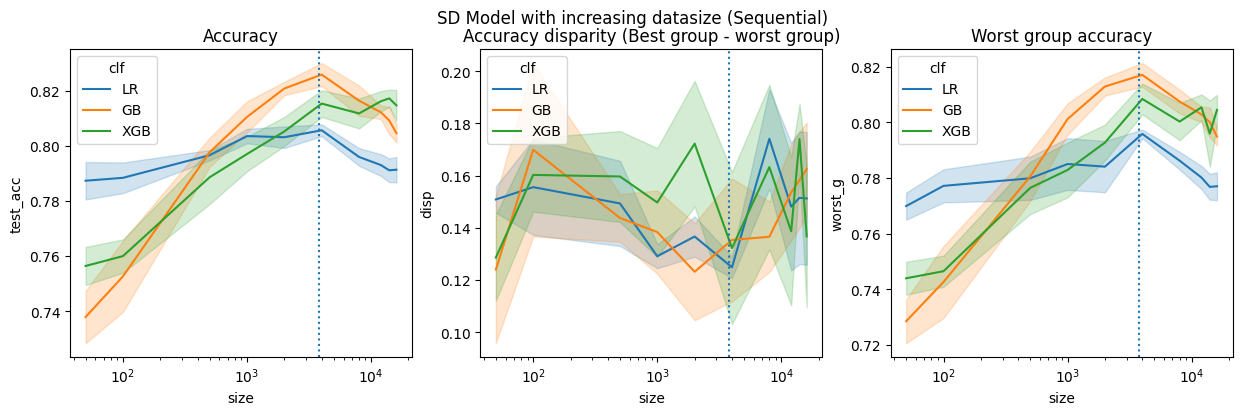

In [326]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x='size', y='test_acc', hue='clf', errorbar='se', ax=axes[0])
axes[0].axvline(x=len(X_train), linestyle=':')
axes[0].set_xscale('log')
axes[0].set_title("Accuracy")

sns.lineplot(data=results_df, x='size', y='disp', hue='clf', errorbar='se', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
axes[1].axvline(x=len(X_train), linestyle=':')
axes[1].set_xscale('log')

sns.lineplot(data=results_df, x='size', y='worst_g', hue='clf', errorbar='se', ax=axes[2])
axes[2].set_title("Worst group accuracy")
axes[2].axvline(x=len(X_train), linestyle=':')
axes[2].set_xscale('log')
if mixture: 
    plt.suptitle(f"{state} Model with increasing datasize (Mixture)")
else: 
    plt.suptitle(f"{state} Model with increasing datasize (Sequential)")

In [88]:
results = [] 
state='SD'
year='2018'
train_year = '2014'
size_arr = [50, 100, 500, 1000, 2000, 4000, 8000]
for run in range(5): 

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_dict[state][year]['x'], 
        data_dict[state][year]['y'], 
        data_dict[state][year]['g'], test_size=0.2, random_state=run)

    X_joint = np.concatenate((X_train, 
                            data_dict[state][train_year]['x']))
    y_joint = np.concatenate((y_train, 
                            data_dict[state][train_year]['y']))
    g_joint = np.concatenate((group_train, 
                            data_dict[state][train_year]['g']))

    for clf in clf_dict.keys(): 

        for size in size_arr: 
            if clf == 'XBG': 
                model = make_pipeline(StandardScaler(), 
                                      clf_dict[clf](objective="binary:logistic"))
            else: 
                model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_joint[:size], y_joint[:size])

            yhat = model.predict(X_test)
            corr = yhat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)


            results.append({
                'train_acc': train_acc, 
                'test_acc': test_acc, 
                'disp': max(g_acc_arr) - min(g_acc_arr),
                'worst_g': min(g_acc_arr), 
                'size': size, 
                'run': run, 
                'clf': clf, 
            })

Text(0.5, 0.98, 'Model with increasing datasize')

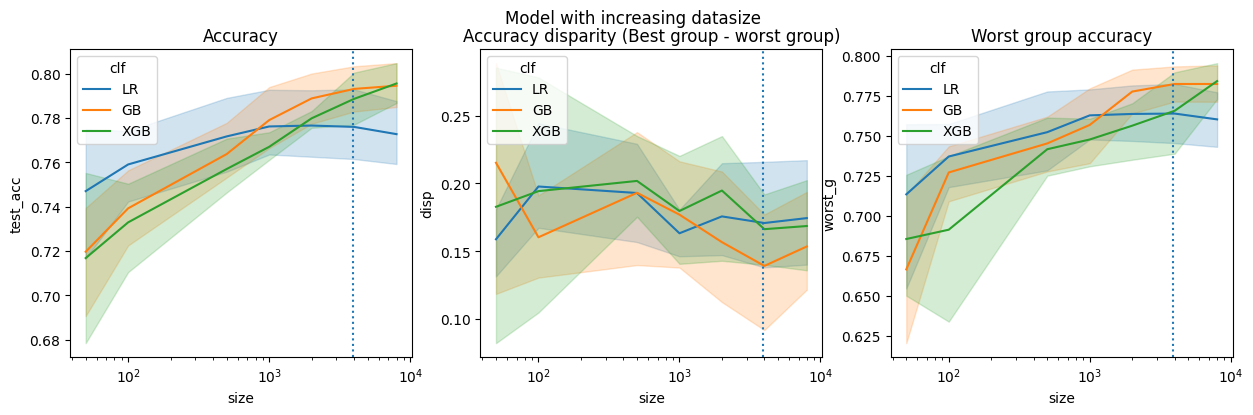

In [89]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x='size', y='test_acc', hue='clf', ax=axes[0])
axes[0].axvline(x=len(X_train), linestyle=':')
axes[0].set_xscale('log')
axes[0].set_title("Accuracy")

sns.lineplot(data=results_df, x='size', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
axes[1].axvline(x=len(X_train), linestyle=':')
axes[1].set_xscale('log')

sns.lineplot(data=results_df, x='size', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
axes[2].axvline(x=len(X_train), linestyle=':')
axes[2].set_xscale('log')
plt.suptitle(f"Model with increasing datasize")

## KL estimate

In [306]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import scipy.special as sp
from sklearn.model_selection import GridSearchCV

cx = make_pipeline(StandardScaler(), PCA(n_components=3)) 
cxy = make_pipeline(StandardScaler(), PCA(n_components=5)) 

In [307]:
# run state classifier in above
state_results = results_df
states_mean = state_results.groupby(['state', 'clf']).mean()

best bandwidth: 0.37926901907322497
best bandwidth: 0.37926901907322497


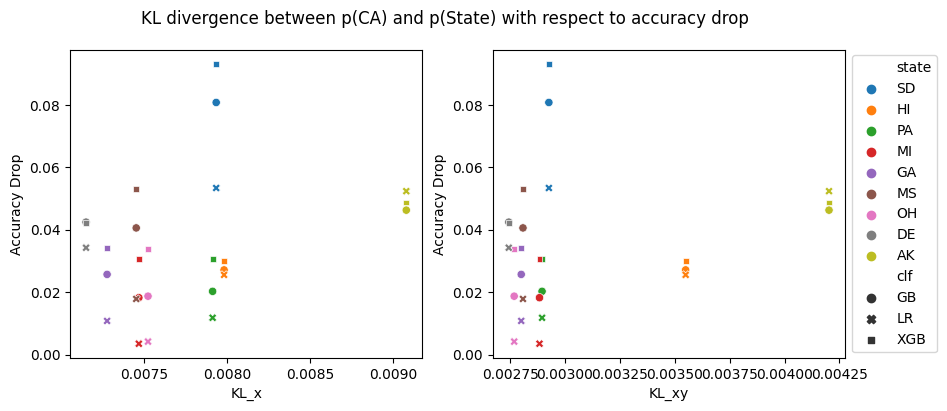

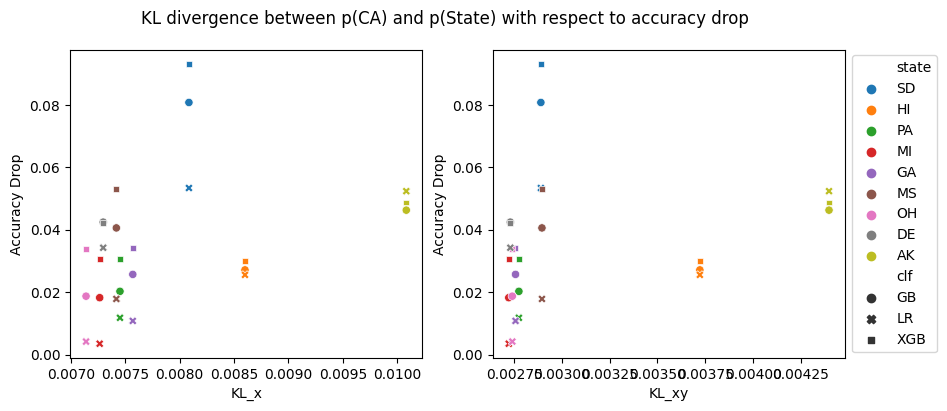

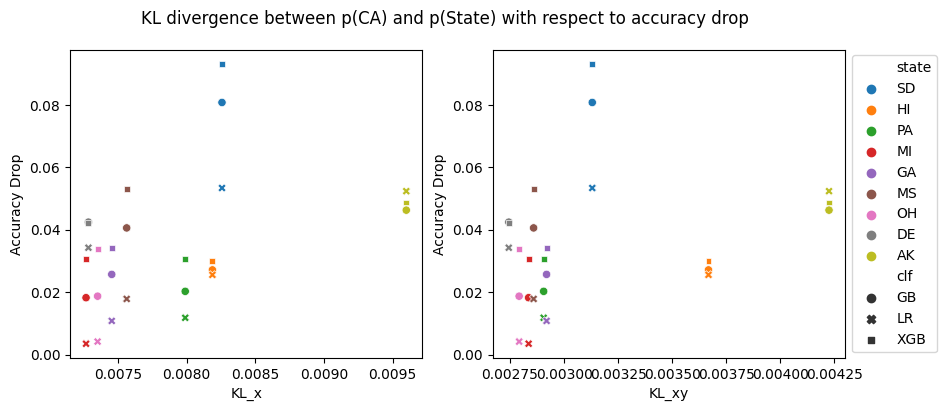

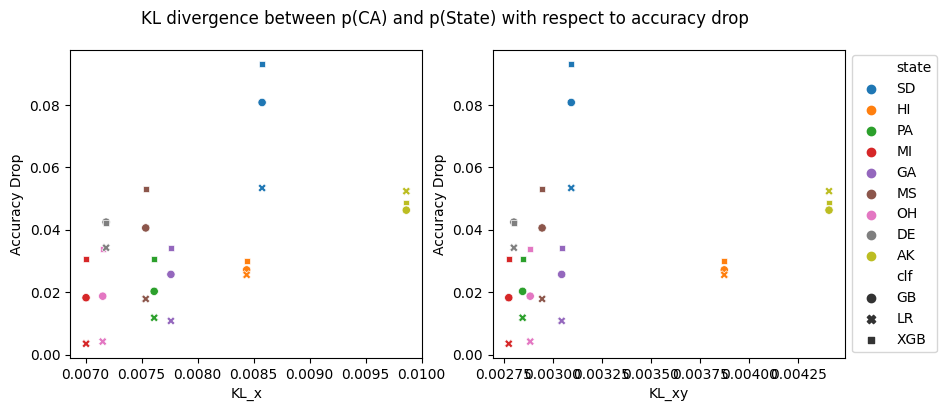

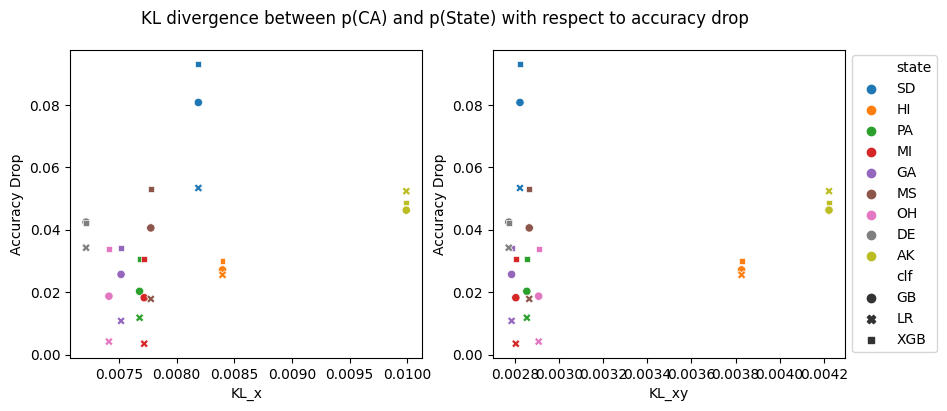

In [315]:
ref_state = 'CA'

samples = 3000 
joint_xy_ref = np.concatenate((data_dict[ref_state][year]['x'],
            data_dict[ref_state][year]['y'].reshape(-1, 1)), axis=1)

incl = np.asarray(random.sample(range(len(joint_xy_ref)), samples*2))

data_xy = cxy.fit_transform(joint_xy_ref[incl])
data_x = cx.fit_transform(data_dict[ref_state][year]['x'][incl])

params = {"bandwidth": np.logspace(-1, 10, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data_xy)
kdexy = grid.best_estimator_
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

grid = GridSearchCV(KernelDensity(), params)
grid.fit(data_x)
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
kdex = grid.best_estimator_

# fix transform 
kdexy.fit(data_xy)
kdex.fit(data_x)

incl = np.asarray(random.sample(range(len(joint_xy_ref)), samples))
px_ref = np.exp(kdex.score_samples(cx.transform(data_dict[ref_state][year]['x'][incl])))
pxy_ref = np.exp(kdexy.score_samples(cxy.transform(joint_xy_ref[incl])))

num_iter = 5
for i in range(num_iter): 
    kl_df = pd.DataFrame()
    for state in data_dict.keys(): 
        if state != ref_state: 
            joint_xy = np.concatenate((data_dict[state][year]['x'],
                data_dict[state][year]['y'].reshape(-1, 1)), axis=1)

            diff_df = states_mean.loc[ref_state] - states_mean.loc[state]
            incl = np.asarray(random.sample(range(len(joint_xy)), samples))

            qx_ref = np.exp(kdex.score_samples(cx.transform(data_dict[state][year]['x'][incl])))
            qxy_ref = np.exp(kdexy.score_samples(cxy.transform(joint_xy[incl])))

            diff_df['KL_x'] = sp.kl_div(px_ref, qx_ref).mean()

            diff_df['KL_xy'] = sp.kl_div(pxy_ref, qxy_ref).mean()
            diff_df['state'] = state 
            diff_df['iter'] = i 
            kl_df = pd.concat((kl_df, diff_df))
            
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.scatterplot(data=kl_df, x='KL_x', y='test_acc', hue='state', style='clf', ax=axes[0], legend=False)
    axes[0].set_ylabel("Accuracy Drop")
    sns.scatterplot(data=kl_df, x='KL_xy', y='test_acc', hue='state', style='clf', ax=axes[1])
    axes[1].set_ylabel("Accuracy Drop")
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.suptitle("KL divergence between p(CA) and p(State) with respect to accuracy drop")

## Relative KL Difference

In [ ]:
# calculate KL to current data vs kl to new dataset
# scatter plot x=excess kl y = accuracy improvement, these points should come from many states: 

# sequential

results = [] 
state='SD'
year='2014'
mixture = False  
size_arr = [3500, 7500]
for extra_state in data_dict.keys():
    if extra_state != state: 
        for run in range(1): 
            X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                data_dict[state][year]['x'], 
                data_dict[state][year]['y'], 
                data_dict[state][year]['g'], test_size=0.25, random_state=run)

            X_joint = np.concatenate((X_train, 
                                    data_dict[extra_state][year]['x']))
            y_joint = np.concatenate((y_train, 
                                    data_dict[extra_state][year]['y']))
            g_joint = np.concatenate((group_train, 
                                    data_dict[extra_state][year]['g']))

        #     if mixture: 
        #         p = np.random.permutation(len(X_joint))
        #         X_joint = X_joint[p]
        #         y_joint = y_joint[p]
        #         g_joint = g_joint[p]

            for clf in clf_dict.keys(): 

                for size in size_arr: 
                    if clf == 'XBG': 
                        model = make_pipeline(StandardScaler(), 
                                              clf_dict[clf](objective="binary:logistic"))
                    else: 
                        model = make_pipeline(StandardScaler(), clf_dict[clf]())

                    model.fit(X_joint[:size], y_joint[:size])

                    yhat = model.predict(X_test)
                    corr = yhat == y_test
                    g_acc_arr = mt.group_accuracy(corr, group_test)

                    train_acc = model.score(X_train, y_train)

                    test_acc = model.score(X_test, y_test)

                    results.append({
                        'train_acc': train_acc, 
                        'test_acc': test_acc, 
                        'disp': max(g_acc_arr) - min(g_acc_arr),
                        'worst_g': min(g_acc_arr), 
                        'size': size, 
                        'run': run, 
                        'clf': clf, 
                        'extra_state': extra_state, 
                    })

In [333]:
results_df = pd.DataFrame(results)

In [ ]:
results_df[results_df['size'] == 3500]['test_acc'] - results_df[results_df['size'] == 7500]['test_acc']